### Imports

In [6]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import optuna
    import torch
    import os
    import random
    random.seed(3111)
    import h5py
    import matplotlib.pyplot as plt
    import numpy as np
    from torch.nn.functional import mse_loss
    from simulai.math.integration import LSODA, ClassWrapper, RK4
    from simulai.math.differentiation import CollocationDerivative
    from simulai.rom import POD
    from simulai.io import Reshaper
    from simulai.simulation import Pipeline
    from simulai.regression import OpInf
    import vtk
if os.path.split(os.getcwd())[-1] == "python":
    os.chdir(os.path.split(os.getcwd())[0]) # change directory

### Read data

In [7]:
datasetSize = "big" # choose dataset size
if datasetSize == "normal":
  datasetPath = ".\\dataset\\OpInfData.h5"
elif datasetSize == "big":
  # file of bigger dataset in desktop,
  # since it can't be uploaded to github
  datasetPath = os.environ["desktopPath"] + "\\vtkFiles\\OpInfData\\OpInfDataBig.h5"
# dataset with higher time resolution
with h5py.File(datasetPath, 'r') as f:
  # raw data is matrix with 'timestep' rows
  # and 'nodal pressure' columns.
  # original values
  # opInfData = np.array(f["OpInfData"], dtype = np.float32)[:-1]
  # values normalized in [0, 1]
  # opInfData = np.array(f["unitData"], dtype = np.float32)[:-1]
  # statistically standardized values
  opInfData = np.array(f["standardData"], dtype = np.float32)[:-1]
  # node coordinates is 2 x 'number of nodes' matrix.
  # first row is x; second, y
  nodeCoord = np.array(f["nodeCoords"], dtype = np.float32)
  # mesh connectivity of nodes
  nodeConn = np.array(f["nodeConnectivity"], dtype = np.int32) - 1

for var in [opInfData, nodeCoord, nodeConn]:
  print(type(var))
  print(var.shape)

<class 'numpy.ndarray'>
(10050, 3362)
<class 'numpy.ndarray'>
(2, 3362)
<class 'numpy.ndarray'>
(12672,)


### POD

Dimension reduction using Proper Orthogonal Decomposition

In [8]:
# Instantiating a Pipeline to prepare data
rom_config = {'n_components': 100} # new number of dimensions
pipeline = Pipeline(
  stages = [('data_preparer', Reshaper()),
  ('rom', POD(config = rom_config))]
)
# Executing the workflow
pipeline.exec(input_data = opInfData)
projectedData = pipeline.project_data(data = opInfData)
reconstructedData = pipeline.reconstruct_data(data = projectedData)
print(f"\nraw data shape: {opInfData.shape}")
print(f"projectedData shape: {projectedData.shape}")
print(f"reconstructedData shape: {reconstructedData.shape}")
print("Reconstruction MSE = {:.4e}".format(mse_loss(
    torch.tensor(reconstructedData), torch.tensor(opInfData)
).item()))

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.00787135399878025
Relative Modal Energy 0.9990428686141968
Executed operation POD.
Applying the global reconstruction strategy.

raw data shape: (10050, 3362)
projectedData shape: (10050, 100)
reconstructedData shape: (10050, 3362)
Reconstruction MSE = 7.9968e-04


### Data split

In [9]:
# timesteps
if datasetSize == "normal":
  dt = 1.0 / 500 / 80
  timeRange = np.arange(0, 1005 * dt, dt)
elif datasetSize == "big":
  dt = 1.0 / 500 / 800
  timeRange = np.arange(0, 10050 * dt, dt)
# augment dataset with estimates of time derivatives
diff = CollocationDerivative(config = {})
derivativeData = diff.solve(data = projectedData, x = timeRange)
# split dataset
splitIndex = np.int32(len(timeRange) * 0.75)
dataTrain = projectedData[:splitIndex]
dataTest = projectedData[splitIndex:]
dataDerivativeTrain = derivativeData[:splitIndex]
dataDerivativeTest = derivativeData[splitIndex:]
timeTrain = timeRange[:splitIndex]
timeTest = timeRange[splitIndex:]

print(f"dataTrain shape: {dataTrain.shape}")
print(f"dataTest shape: {dataTest.shape}")
print(f"dataDerivativeTrain shape: {dataDerivativeTrain.shape}")
print(f"dataDerivativeTest shape: {dataDerivativeTest.shape}")
print(f"timeTrain shape: {timeTrain.shape}")
print(f"timeTest shape: {timeTest.shape}")

Performing Collocation Derivation.
dataTrain shape: (7537, 100)
dataTest shape: (2513, 100)
dataDerivativeTrain shape: (7537, 100)
dataDerivativeTest shape: (2513, 100)
timeTrain shape: (7537,)
timeTest shape: (2513,)


### Best parameters
Hyperparameter optimization with the Optuna package to find the optimal combination of regularization weights.

In [10]:
# objective is a function which returns a scalar
# that must be minimized
def objective(trial):
    print("")
    # setup optimization parameters (regularization weights)
    lambdaLinear = trial.suggest_float('lambdaLinear', 0, 1e3, step = 50)
    lambdaQuad = trial.suggest_float('lambdaQuad', 0, 1e3, step = 50)
    # OpInf least squares minimization in embedded space
    _opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
    _opInfObject.set(lambda_linear = lambdaLinear, lambda_quadratic = lambdaQuad)
    _opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)
    # Time integration through test time interval
    _opInfObject.construct_K_op()
    _rightOperator = ClassWrapper(_opInfObject)
    _solver = LSODA(_rightOperator)
    _testIntegration = _solver.run(dataTrain[-1], timeTest)
    # return MSE of time integration in test split
    print("")
    return np.square(np.subtract(_testIntegration, dataTest)).mean()
# create study object with desired sampler
study = optuna.create_study(
    sampler = optuna.samplers.RandomSampler()
    # sampler = optuna.samplers.CmaEsSampler()
    # sampler = optuna.samplers.QMCSampler()
)
# run optimization
study.optimize(objective, n_trials = 30, show_progress_bar = True)
# results
print(f"\nBest Parameters: {study.best_params}")
print(f"Best objective value: {study.best_value}")

[I 2023-07-06 16:19:47,534] A new study created in memory with name: no-name-4254a721-21f6-4266-9bbf-6b9787f85427
  0%|          | 0/30 [00:00<?, ?it/s]


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:   3%|▎         | 1/30 [00:39<18:53, 39.09s/it]


[I 2023-07-06 16:20:26,619] Trial 0 finished with value: 8.180234991040345 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 750.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:   7%|▋         | 2/30 [01:17<18:02, 38.65s/it]


[I 2023-07-06 16:21:04,956] Trial 1 finished with value: 13.535832477432649 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 100.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  10%|█         | 3/30 [01:55<17:14, 38.30s/it]


[I 2023-07-06 16:21:42,856] Trial 2 finished with value: 12.851178926124966 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 150.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  13%|█▎        | 4/30 [02:34<16:42, 38.55s/it]


[I 2023-07-06 16:22:21,782] Trial 3 finished with value: 8.632493647448678 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 950.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  17%|█▋        | 5/30 [03:12<16:03, 38.56s/it]


[I 2023-07-06 16:23:00,357] Trial 4 finished with value: 8.625963293021146 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 700.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  20%|██        | 6/30 [03:50<15:21, 38.40s/it]


[I 2023-07-06 16:23:38,446] Trial 5 finished with value: 11.547709734970889 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 200.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  23%|██▎       | 7/30 [04:30<14:53, 38.85s/it]


[I 2023-07-06 16:24:18,219] Trial 6 finished with value: 8.39240414560871 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 850.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  27%|██▋       | 8/30 [05:09<14:17, 38.98s/it]


[I 2023-07-06 16:24:57,489] Trial 7 finished with value: 8.369281655100705 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 500.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  30%|███       | 9/30 [05:48<13:37, 38.95s/it]


[I 2023-07-06 16:25:36,351] Trial 8 finished with value: 9.282285801338173 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 350.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  33%|███▎      | 10/30 [06:27<12:55, 38.79s/it]


[I 2023-07-06 16:26:14,793] Trial 9 finished with value: 11.497663826408559 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 200.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  37%|███▋      | 11/30 [07:05<12:13, 38.60s/it]


[I 2023-07-06 16:26:52,958] Trial 10 finished with value: 8.434966403229556 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 1000.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 8.18023:  40%|████      | 12/30 [07:43<11:34, 38.58s/it]


[I 2023-07-06 16:27:31,499] Trial 11 finished with value: 8.236377241833605 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 750.0}. Best is trial 0 with value: 8.180234991040345.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  43%|████▎     | 13/30 [08:22<10:54, 38.50s/it]


[I 2023-07-06 16:28:09,818] Trial 12 finished with value: 8.165008018638146 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 650.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  47%|████▋     | 14/30 [09:00<10:15, 38.44s/it]


[I 2023-07-06 16:28:48,120] Trial 13 finished with value: 8.19600807439658 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 800.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  50%|█████     | 15/30 [09:39<09:38, 38.57s/it]


[I 2023-07-06 16:29:26,995] Trial 14 finished with value: 8.760225338897556 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 800.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  53%|█████▎    | 16/30 [10:18<09:00, 38.59s/it]

[I 2023-07-06 16:30:05,440] Trial 15 finished with value: 8.327741121115887 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 500.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  57%|█████▋    | 17/30 [10:56<08:20, 38.52s/it]


[I 2023-07-06 16:30:43,977] Trial 16 finished with value: 8.568026017245936 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 450.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  60%|██████    | 18/30 [11:34<07:42, 38.53s/it]


[I 2023-07-06 16:31:22,526] Trial 17 finished with value: 9.909718551972286 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 300.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  63%|██████▎   | 19/30 [12:15<07:09, 39.05s/it]


[I 2023-07-06 16:32:02,793] Trial 18 finished with value: 9.291885412613372 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 800.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  67%|██████▋   | 20/30 [12:53<06:28, 38.80s/it]


[I 2023-07-06 16:32:41,013] Trial 19 finished with value: 8.410195995001583 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 800.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  70%|███████   | 21/30 [13:31<05:47, 38.63s/it]


[I 2023-07-06 16:33:19,256] Trial 20 finished with value: 8.165008018638146 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 650.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  73%|███████▎  | 22/30 [14:09<05:08, 38.50s/it]


[I 2023-07-06 16:33:57,459] Trial 21 finished with value: 9.27889371534114 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 350.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  77%|███████▋  | 23/30 [14:49<04:32, 38.96s/it]


[I 2023-07-06 16:34:37,471] Trial 22 finished with value: 9.39381006635175 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 850.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  80%|████████  | 24/30 [15:29<03:54, 39.06s/it]


[I 2023-07-06 16:35:16,773] Trial 23 finished with value: 10.31080047028492 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 300.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  83%|████████▎ | 25/30 [16:09<03:16, 39.28s/it]


[I 2023-07-06 16:35:56,583] Trial 24 finished with value: 10.635065020466826 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 250.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  87%|████████▋ | 26/30 [16:47<02:36, 39.02s/it]


[I 2023-07-06 16:36:34,986] Trial 25 finished with value: 8.342946312018489 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 900.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  90%|█████████ | 27/30 [17:26<01:56, 38.95s/it]


[I 2023-07-06 16:37:13,763] Trial 26 finished with value: 8.407920952292258 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 950.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  93%|█████████▎| 28/30 [18:06<01:18, 39.25s/it]


[I 2023-07-06 16:37:53,714] Trial 27 finished with value: 10.31080047028492 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 300.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501:  97%|█████████▋| 29/30 [18:44<00:39, 39.05s/it]


[I 2023-07-06 16:38:32,295] Trial 28 finished with value: 12.427696128773022 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 150.0}. Best is trial 12 with value: 8.165008018638146.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 12. Best value: 8.16501: 100%|██████████| 30/30 [19:23<00:00, 38.77s/it]


[I 2023-07-06 16:39:10,684] Trial 29 finished with value: 8.250378564890168 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 600.0}. Best is trial 12 with value: 8.165008018638146.

Best Parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 650.0}
Best objective value: 8.165008018638146


Experiments were conducted to choose between the samplers RandomSampler, CmaEsSampler and QMCSampler (1h, 90 trials each). Random sampler achieved the smallest test interval MSE.

### OpInf fitting
OpInf least squares minimization in projected space. Find optimal coefficients of quadratic system of ODEs in projected space.

In [11]:
# create OpInf object
opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
# set optimal regularization weights from previous step
opInfObject.set(
    lambda_linear = study.best_params["lambdaLinear"],
    # lambda_linear = 1000,
    lambda_quadratic = study.best_params["lambdaQuad"]
    # lambda_quadratic = 650
)
# least squares fit
opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


### Time integration
Integrate in time the ODE system approximated in the previous code cell. Start in the last time step of the training split, and integrate through the test split

In [12]:
opInfObject.construct_K_op()
rightOperator = ClassWrapper(opInfObject)
solver = LSODA(rightOperator)
testIntegration = solver.run(dataTrain[-1], timeTest)
# output is matrix with 'test time steps' rows and
# 'embedded dimensions' columns. Represents field evolution
# throughout time steps in test split (in projected space)
print(f"testIntegration shape: {testIntegration.shape}")
# After time integration, return to original high dimensional space
reconstructIntTest = pipeline.reconstruct_data(data = testIntegration)
print(f"reconstructIntTest shape: {reconstructIntTest.shape}")

testIntegration shape: (2513, 100)
Applying the global reconstruction strategy.
reconstructIntTest shape: (2513, 3362)


### Model error

In [13]:
# MSE of time integration over test split in embedded space
mseLowDim = mse_loss(torch.tensor(testIntegration), torch.tensor(dataTest))
print("Reduced order MSE = {:.4e}".format(mseLowDim.item()))
# MSE of time integration over test split in original space
mseHighDim = mse_loss(torch.tensor(reconstructIntTest), torch.tensor(opInfData[splitIndex:]))
print("Full order MSE = {:.4e}".format(mseHighDim.item()))

Reduced order MSE = 8.1650e+00
Full order MSE = 2.4483e-01


### Integration error history
Sample some positions and plot their time integration error histories

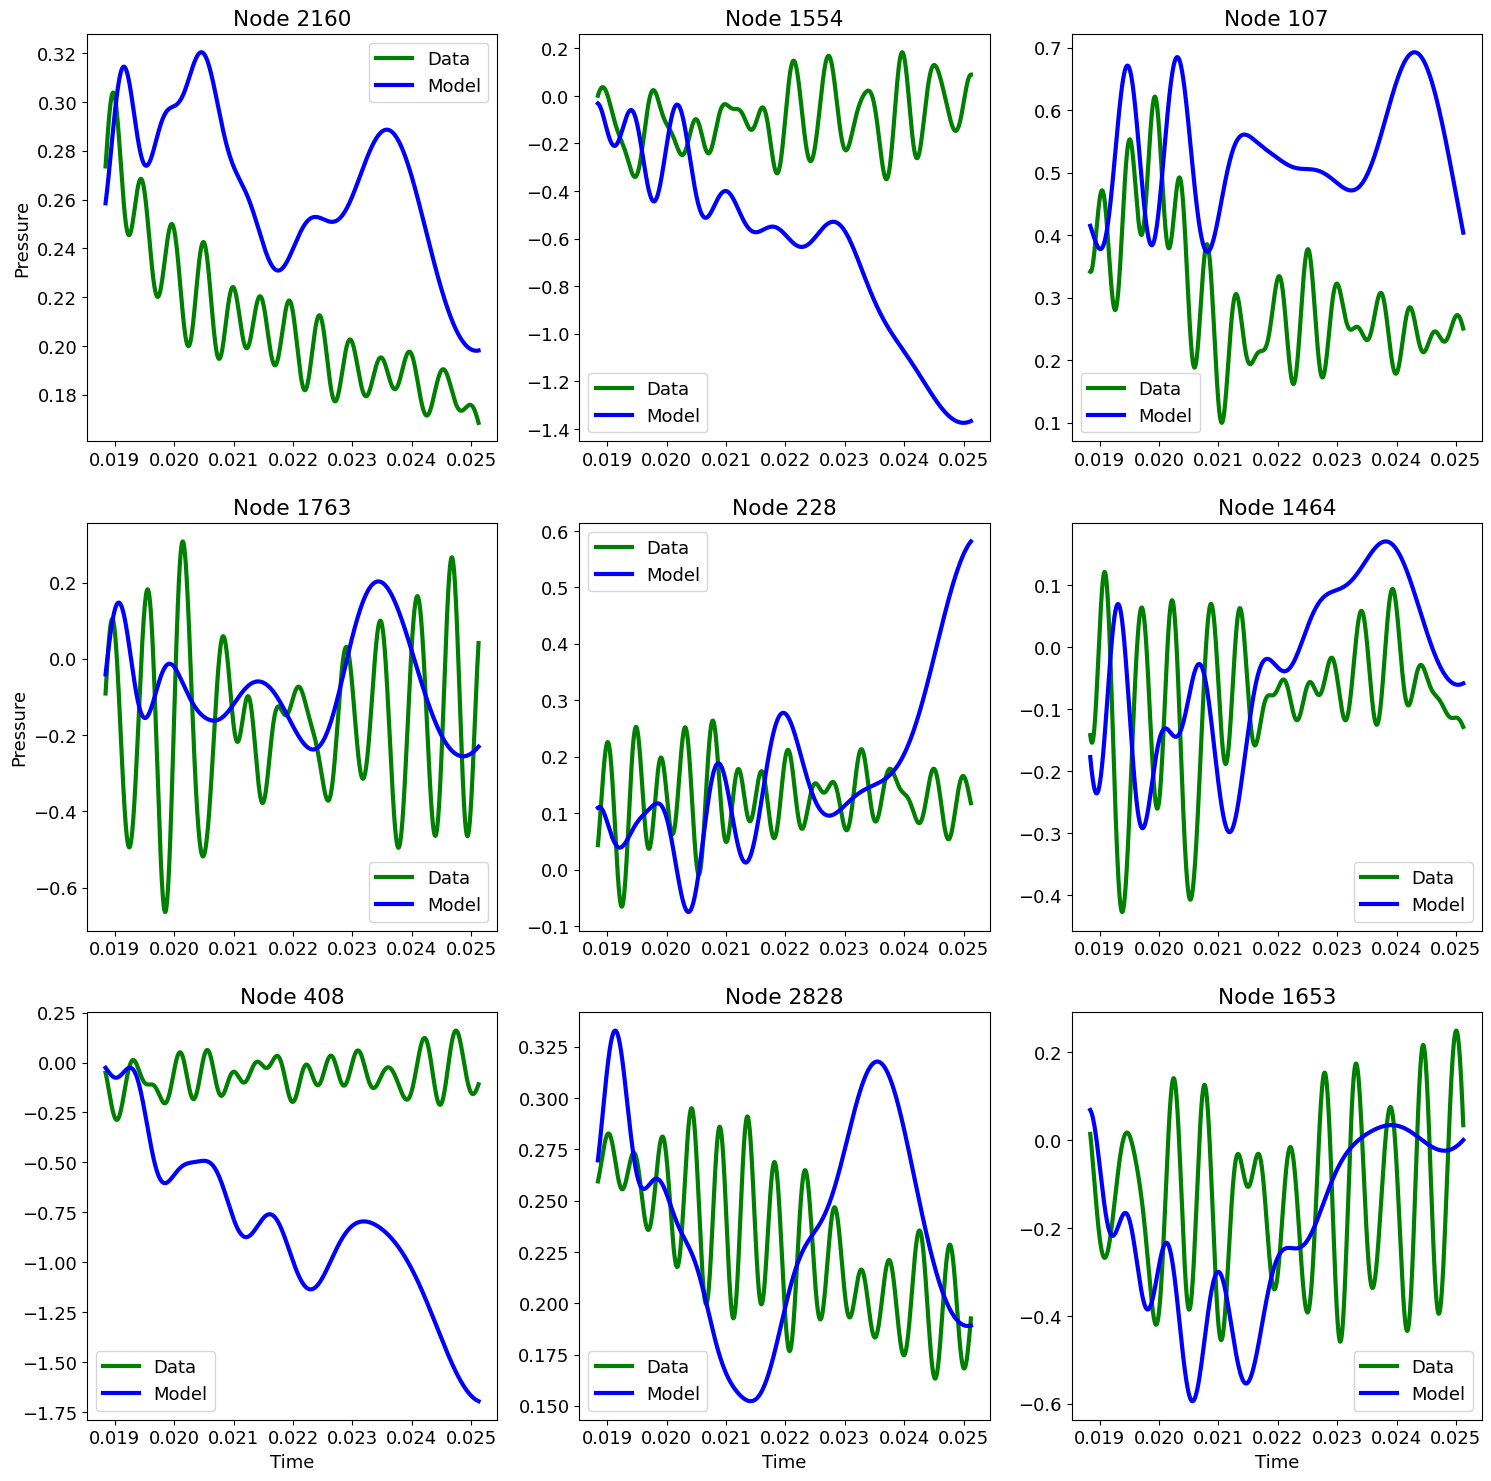

In [14]:
plt.rcParams['font.size'] = 13
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTest, opInfData[-timeTest.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTest, reconstructIntTest[-timeTest.shape[0]:, point],
    label = "Model", color = 'blue', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Reconstruction error
Sample some points and plot their reconstruction error histories in the train split

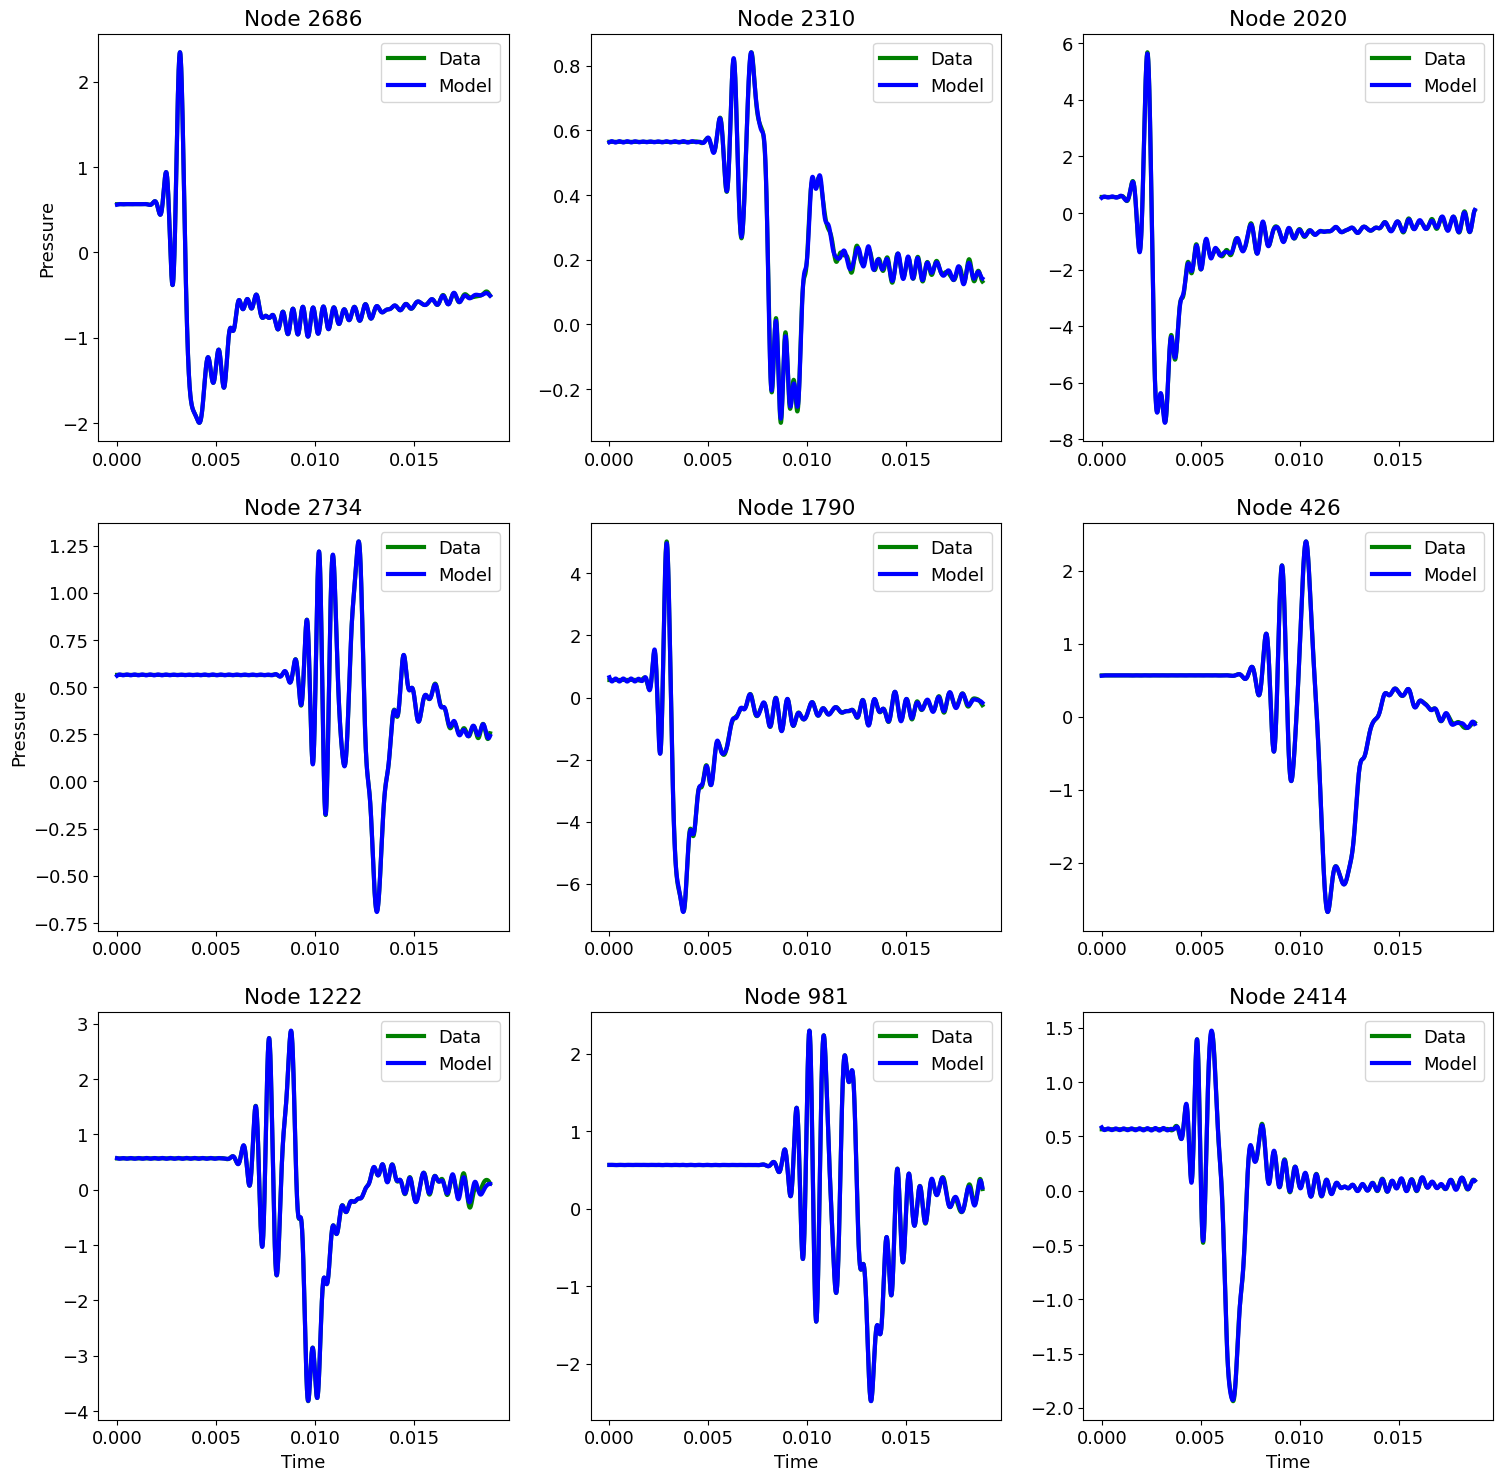

In [15]:
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTrain, opInfData[:timeTrain.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTrain, reconstructedData[:timeTrain.shape[0]:, point],
    label = "Model", color = 'blue', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

### Animation

In [16]:
# create folder with random name
folderName = np.random.randint(0, 1e8)
os.mkdir(os.environ["desktopPath"] + f"\\vtkFiles\\animation\\{folderName}")
# iterate in time steps
for step in range(reconstructIntTest.shape[0]):
    # create vtk object
    my_vtk_dataset = vtk.vtkUnstructuredGrid()
    # create points by defining coordinates
    points = vtk.vtkPoints()
    for id in range(reconstructIntTest.shape[1]):
        points.InsertPoint(id, [nodeCoord[0, id], nodeCoord[1, id], 0])
    my_vtk_dataset.SetPoints(points)
    # create elements by establishing connectivity
    numberOfElements = 3168
    my_vtk_dataset.Allocate(numberOfElements)
    for eleID in range(numberOfElements):
        my_vtk_dataset.InsertNextCell(
            vtk.VTK_QUAD, 4,
            np.array(nodeConn[4 * eleID : 4 * (eleID + 1)])
        )
    # create data arrays
    array = vtk.vtkDoubleArray()
    array.SetNumberOfComponents(1)
    array.SetNumberOfTuples(reconstructIntTest.shape[1])
    array.SetName('pressure')
    # set values in all nodes for current time step
    for id in range(reconstructIntTest.shape[1]):
        array.SetTuple(id, [reconstructIntTest[step, id]])
    my_vtk_dataset.GetPointData().AddArray(array)
    # save data to disk
    writer = vtk.vtkXMLUnstructuredGridWriter()
    writer.SetFileName(os.environ["desktopPath"] + f"\\vtkFiles\\animation\\{folderName}\\output-{step}.vtu")
    writer.SetInputData(my_vtk_dataset)
    writer.Write()